In [1]:
import copy

import torch
import torchvision
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

import numpy as np
from sklearn.mixture import GaussianMixture as GMM
from scipy.stats import norm

from utils import plot_sparsity_matrix,weight_histograms,set_all_seeds, plot_weight_histograms, make_paths_relative_to_root

import data as module_data
import models as module_arch
import evaluation as module_metric

import quantization as module_quantize
import pruning as module_prune

from parse_config import ConfigParser
from trainer.trainer import Trainer

make_paths_relative_to_root()

In [2]:
# Retrieve a configuration
config_dict = {'resume':'runs/models/Mnist_LeNet5/baseline/checkpoint-epoch15.pth'}

config = ConfigParser.from_dict(config_dict)

logger = config.get_logger('train')

data_loader = config.init_obj('data_loader', module_data)
valid_data_loader = data_loader.split_validation()

In [3]:
# build model architecture, then print to console
model = config.init_obj('arch', module_arch)
model.load_state_dict(torch.load(config.resume)['state_dict'])
logger.info(model)

# prepare for (multi-device) GPU training
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# get function handles of loss and metrics
criterion = getattr(F, config['loss'])
metrics = [getattr(module_metric, met) for met in config['metrics']]

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc): Linear(in_features=400, out_features=120, bias=True)
  (fc1): Linear(in_features=120, out_features=84, bias=True)
  (fc2): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0, inplace=False)
)


# Pruning vs sparsity

In [22]:
from pruning import prune_model
from copy import deepcopy
from collections import OrderedDict

sparsities = np.linspace(.1,1,9)
train = False

sensitivities = OrderedDict()
for pruner in config['pruners']:
    for param_name in pruner['levels'].keys():
        if model.state_dict()[param_name].dim() not in [2, 4]:
            continue

        # Make a copy of the model, because when we apply the zeros mask (i.e.
        # perform pruning), the model's weights are altered
        model_cpy = deepcopy(model)

        # build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
        trainable_params = filter(lambda p: p.requires_grad, model_cpy.parameters())
        optimizer = config.init_obj('optimizer', torch.optim, trainable_params)
        lr_scheduler = config.init_obj('lr_scheduler', torch.optim.lr_scheduler, optimizer)

        trainer = Trainer(model_cpy, criterion, metrics, optimizer,
                          config=config,
                          device=device,
                          data_loader=data_loader,
                          valid_data_loader=valid_data_loader,
                  lr_scheduler=lr_scheduler)

        sensitivity = OrderedDict()
        for l in sparsities:
            sparsity = float(l)
            # Element-wise sparsity
            levels = {param_name: sparsity}

            fn = getattr(module_prune, pruner["type"])
            if logger is not None:
                logger.info("Testing sensitivity of {} to {} [{:.2f}% sparsity]".format(
                    param_name,fn.__name__, sparsity * 100))
            # Create the pruner (a level pruner), the pruning policy and the
            # pruning schedule.


            iterations = 1
            for it in range(iterations):
                prune_model(model_cpy, fn, levels, logger)

                # Test and record the performance of the pruned model
                if train:
                    trainer.train()
            _, acc1, acc5 = trainer._valid_epoch(-1).values()
            if logger is not None:
                logger.info(
                    "Tested sensitivity of {} [ sparsity amount:{:.1f} ] | acc@1:{:.2f} | acc@5:{:.2f}"
                    .format(param_name,
                            sparsity,
                            acc1, acc5))
            sensitivity[sparsity] = [acc1, acc5]
        sensitivities[param_name] = sensitivity

Testing sensitivity of conv1.weight to l1_unstructured [10.00% sparsity]
Pruning conv1.weight with amount 0.10
Pruned 15 weights (90.00% retained)
Tested sensitivity of conv1.weight [ sparsity amount:0.1 ] | acc@1:1.00 | acc@5:1.00
Testing sensitivity of conv1.weight to l1_unstructured [21.25% sparsity]
Pruning conv1.weight with amount 0.21
Pruned 44 weights (70.67% retained)
Tested sensitivity of conv1.weight [ sparsity amount:0.2 ] | acc@1:1.00 | acc@5:1.00
Testing sensitivity of conv1.weight to l1_unstructured [32.50% sparsity]
Pruning conv1.weight with amount 0.33
Pruned 78 weights (48.00% retained)
Tested sensitivity of conv1.weight [ sparsity amount:0.3 ] | acc@1:1.00 | acc@5:1.00
Testing sensitivity of conv1.weight to l1_unstructured [43.75% sparsity]
Pruning conv1.weight with amount 0.44
Pruned 110 weights (26.67% retained)
Tested sensitivity of conv1.weight [ sparsity amount:0.4 ] | acc@1:1.00 | acc@5:1.00
Testing sensitivity of conv1.weight to l1_unstructured [55.00% sparsity

In [23]:
import csv


def sensitivities_to_csv(sensitivities, fname):
    """Create a CSV file listing from the sensitivities dictionary.
    The 'sensitivities' argument is expected to have the dict-of-dict structure
    described in the documentation of perform_sensitivity_test.
    """
    with open(fname, 'w') as csv_file:
        writer = csv.writer(csv_file)
        # write the header
        writer.writerow(['parameter', 'sparsity', 'top1', 'top5', 'loss'])
        for param_name, sensitivity in sensitivities.items():
            for sparsity, values in sensitivity.items():
                writer.writerow([param_name] + [sparsity] + list(values))


try:
    # sudo apt-get install python3-tk
    import matplotlib
    matplotlib.use('Agg')
    import matplotlib.pyplot as plt
except ImportError:
    print("WARNING: Function plot_sensitivity requires package matplotlib which"
          "is not installed in your execution environment.\n"
          "Skipping the PNG file generation")

fig = plt.figure()
for param_name, sensitivity in sensitivities.items():
    sense = [values[0] for sparsity, values in sensitivity.items()]
    sparsities = [sparsity for sparsity, values in sensitivity.items()]
    print(sense,sparsities)
    plt.plot(sparsities, sense, label=param_name)

plt.ylabel('top1 Accuracy')
plt.xlabel('sparsity')
plt.title('Pruning Sensitivity')
plt.grid()
plt.legend(loc='lower left',
           ncol=2, borderaxespad=0.)
fig.savefig('pruning-sensitivity-analysis-notrain.png')
sensitivities_to_csv(sensitivities,'pruning-sensitivity-analysis-notrain.csv')

[0.998314019756839, 0.9983377659574468, 0.9986702127659575, 0.996841755319149, 0.9954882218844985, 0.9676339285714286, 0.933843085106383, 0.0928951367781155, 0.0928238981762918] [0.1, 0.21250000000000002, 0.325, 0.4375, 0.55, 0.6625, 0.775, 0.8875, 1.0]
[0.9983377659574468, 0.9981715425531915, 0.9986464665653496, 0.996343085106383, 0.9676814209726443, 0.7234517477203648, 0.37955927051671734, 0.15874335106382978, 0.09277640577507598] [0.1, 0.21250000000000002, 0.325, 0.4375, 0.55, 0.6625, 0.775, 0.8875, 1.0]
[0.9983377659574468, 0.997815349544073, 0.9975066489361702, 0.9951795212765957, 0.9867021276595744, 0.9585153875379939, 0.761231952887538, 0.24411094224924013, 0.09280015197568389] [0.1, 0.21250000000000002, 0.325, 0.4375, 0.55, 0.6625, 0.775, 0.8875, 1.0]
[0.9983377659574468, 0.9980053191489362, 0.9973404255319149, 0.9940159574468085, 0.9881743920972644, 0.9436502659574468, 0.6968322568389057, 0.29212575987841943, 0.1015862462006079] [0.1, 0.21250000000000002, 0.325, 0.4375, 0.55, 

# Quantization vs bits

In [4]:
from trainer.compression_trainer import CompressionTrainer
from copy import deepcopy
from collections import OrderedDict

train = False

fns = ['linear_quantization','forgy_quantization','density_quantization']
bits = 8

sensitivities = OrderedDict()

# build optimizer, learning rate scheduler. delete every lines containing lr_scheduler for disabling scheduler
trainable_params = filter(lambda p: p.requires_grad, model.parameters())
optimizer = config.init_obj('optimizer', torch.optim, trainable_params)
lr_scheduler = config.init_obj('lr_scheduler', torch.optim.lr_scheduler, optimizer)

trainer = CompressionTrainer(model, criterion, metrics, optimizer,
                  config=config,
                  device=device,
                  data_loader=data_loader,
                  valid_data_loader=valid_data_loader,
                  lr_scheduler=lr_scheduler)

trainer.prune()

model = trainer.model

# # avoid model reinitialization inside trainer
config.resume = None

for fn in fns:
    sensitivity = OrderedDict()
    for b in range(1,bits):
        config['quantizer']['type'] = fn

        config['quantizer']['levels'] = {k:b for k in config['quantizer']['levels'].keys()}

        # Make a copy of the model, because when we apply the zeros mask (i.e.
        # perform pruning), the model's weights are altered
        model_cpy = deepcopy(model)

        trainable_params = filter(lambda p: p.requires_grad, model_cpy.parameters())
        optimizer = config.init_obj('optimizer', torch.optim, trainable_params)
        lr_scheduler = config.init_obj('lr_scheduler', torch.optim.lr_scheduler, optimizer)

        trainer = CompressionTrainer(model_cpy, criterion, metrics, optimizer,
                          config=config,
                          device=device,
                          data_loader=data_loader,
                          valid_data_loader=valid_data_loader,
                          lr_scheduler=lr_scheduler)

        trainer.quantize()

        _, acc1,acc5 = trainer._valid_epoch(-1).values()

        sensitivity[b] = [acc1, acc5]
    sensitivities[fn] = sensitivity

Loading checkpoint: runs\models\Mnist_LeNet5\baseline\checkpoint-epoch15.pth ...
Checkpoint loaded. Resume training from epoch 16
Accuracy before compression: 0.9903
   Pruned 51 weights - 99 (66.00%) retained)
   Pruned 2112 weights - 288 (12.00%) retained)
    epoch          : 1
    loss           : 0.025489811674069385
    accuracy       : 0.9927957853757617
    topk_accuracy  : 0.9999814869668247
    val_loss       : 0.0243437032443174
    val_accuracy   : 0.9911426671732522
    val_topk_accuracy: 1.0
    epoch          : 2
    loss           : 0.019787589820505724
    accuracy       : 0.9942424466824644
    topk_accuracy  : 0.9999814869668247
    val_loss       : 0.020903266210881795
    val_accuracy   : 0.9938497340425532
    val_topk_accuracy: 1.0
    epoch          : 3
    loss           : 0.018551391798101356
    accuracy       : 0.9945756812796208
    topk_accuracy  : 0.9999814869668247
    val_loss       : 0.019917802077698263
    val_accuracy   : 0.9934935410334347
    val_

C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  "KMeans is known to have a memory l

    epoch          : 1
    loss           : 0.32038171857736686
    accuracy       : 0.918592903689912
    topk_accuracy  : 0.9984449052132701
    val_loss       : 0.2534989131257889
    val_accuracy   : 0.9453837386018237
    val_topk_accuracy: 0.9991688829787234
    epoch          : 2
    loss           : 0.24735908150249183
    accuracy       : 0.9429560553486797
    topk_accuracy  : 0.9989632701421801
    val_loss       : 0.23911034014630825
    val_accuracy   : 0.9464523176291794
    val_topk_accuracy: 0.9991688829787234
    epoch          : 3
    loss           : 0.23665282338575164
    accuracy       : 0.9440271665538253
    topk_accuracy  : 0.9990002962085308
    val_loss       : 0.22995140165724653
    val_accuracy   : 0.947045972644377
    val_topk_accuracy: 0.9993351063829787
    epoch          : 4
    loss           : 0.22854821002596362
    accuracy       : 0.9453865521327014
    topk_accuracy  : 0.9990928613744076
    val_loss       : 0.22298390751189373
    val_accuracy 

C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  "KMeans is known to have a memory l

    epoch          : 1
    loss           : 0.1115192914717076
    accuracy       : 0.9655789818889641
    topk_accuracy  : 0.9997037914691943
    val_loss       : 0.08241929704363042
    val_accuracy   : 0.9747815349544073
    val_topk_accuracy: 0.9998337765957447
    epoch          : 2
    loss           : 0.06858365911487226
    accuracy       : 0.978593644211239
    topk_accuracy  : 0.9998333827014217
    val_loss       : 0.06618348584371678
    val_accuracy   : 0.9789846124620061
    val_topk_accuracy: 0.9998337765957447
    epoch          : 3
    loss           : 0.05862537426079548
    accuracy       : 0.9812595209884901
    topk_accuracy  : 0.9998333827014217
    val_loss       : 0.060744993547175795
    val_accuracy   : 0.981216755319149
    val_topk_accuracy: 0.9998337765957447
    epoch          : 4
    loss           : 0.05487050986252902
    accuracy       : 0.9825898146580907
    topk_accuracy  : 0.9998704087677726
    val_loss       : 0.05858863212485263
    val_accuracy

C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  "KMeans is known to have a memory l

    epoch          : 1
    loss           : 0.02937035209783993
    accuracy       : 0.9908545616113744
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.03872157923599824
    val_accuracy   : 0.9870108282674772
    val_topk_accuracy: 1.0
    epoch          : 2
    loss           : 0.027984983580996905
    accuracy       : 0.9911481254231551
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.03759136489850092
    val_accuracy   : 0.9876994680851063
    val_topk_accuracy: 1.0
    epoch          : 3
    loss           : 0.027166088923571356
    accuracy       : 0.9914073078876101
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.0369915543272695
    val_accuracy   : 0.9885068389057751
    val_topk_accuracy: 1.0
    epoch          : 4
    loss           : 0.026667322109396
    accuracy       : 0.9917035164184157
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.03673382184686179
    val_accuracy   : 0.9884593465045592
    val_topk_accurac

C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  "KMeans is known to have a memory l

    epoch          : 1
    loss           : 0.022363600843051952
    accuracy       : 0.9934252285037238
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.03437427127178996
    val_accuracy   : 0.9886730623100305
    val_topk_accuracy: 1.0
    epoch          : 2
    loss           : 0.021774443878319946
    accuracy       : 0.993650029620853
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.03396842467717509
    val_accuracy   : 0.988981762917933
    val_topk_accuracy: 1.0
    epoch          : 3
    loss           : 0.021399523077479683
    accuracy       : 0.9938140022004063
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.03379367218610454
    val_accuracy   : 0.9888392857142858
    val_topk_accuracy: 1.0
    epoch          : 4
    loss           : 0.02114466820033576
    accuracy       : 0.9938351599526066
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.03376737832923994
    val_accuracy   : 0.9888392857142858
    val_topk_accur

C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  "KMeans is known to have a memory l

    epoch          : 1
    loss           : 0.02049147462614666
    accuracy       : 0.9940388033175356
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.03463407106291344
    val_accuracy   : 0.9886730623100305
    val_topk_accuracy: 1.0
    epoch          : 2
    loss           : 0.020277955696225095
    accuracy       : 0.9941260790453622
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.034392545940948926
    val_accuracy   : 0.9891479863221884
    val_topk_accuracy: 1.0
    epoch          : 3
    loss           : 0.020107919476061213
    accuracy       : 0.9943535248815166
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.034250541084862134
    val_accuracy   : 0.9892904635258358
    val_topk_accuracy: 1.0
    epoch          : 4
    loss           : 0.01999651455299452
    accuracy       : 0.9944222875761678
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.03411607492338628
    val_accuracy   : 0.9896704027355624
    val_topk_ac

C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  "KMeans is known to have a memory l

    epoch          : 1
    loss           : 0.019646573489006627
    accuracy       : 0.9944434453283684
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.03372066079371391
    val_accuracy   : 0.9888155395136777
    val_topk_accuracy: 1.0
    epoch          : 2
    loss           : 0.019543525797063352
    accuracy       : 0.9944408006093433
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.03367810979227912
    val_accuracy   : 0.9888155395136777
    val_topk_accuracy: 1.0
    epoch          : 3
    loss           : 0.019457072398064754
    accuracy       : 0.9944646030805687
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.033561679603967894
    val_accuracy   : 0.9887917933130699
    val_topk_accuracy: 1.0
    epoch          : 4
    loss           : 0.019401028058248886
    accuracy       : 0.9944619583615437
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.03347681091721863
    val_accuracy   : 0.9886968085106383
    val_topk_a

C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  "KMeans is known to have a memory l

    epoch          : 1
    loss           : 0.019872561243422862
    accuracy       : 0.9943482354434664
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.033816584693069786
    val_accuracy   : 0.9885068389057751
    val_topk_accuracy: 1.0
    epoch          : 2
    loss           : 0.0196907677245216
    accuracy       : 0.9944646030805687
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.03375327880147527
    val_accuracy   : 0.9886730623100305
    val_topk_accuracy: 1.0
    epoch          : 3
    loss           : 0.01957347993137562
    accuracy       : 0.9945174974610698
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.03375472124428191
    val_accuracy   : 0.9886493161094224
    val_topk_accuracy: 1.0
    epoch          : 4
    loss           : 0.01948051457651957
    accuracy       : 0.9945941943127962
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.033578581325313515
    val_accuracy   : 0.9886730623100305
    val_topk_accu

C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  "KMeans is known to have a memory l

    epoch          : 1
    loss           : 0.32007205270901673
    accuracy       : 0.9190054798578199
    topk_accuracy  : 0.998537470379147
    val_loss       : 0.25376454724910413
    val_accuracy   : 0.9448375759878419
    val_topk_accuracy: 0.9990026595744681
    epoch          : 2
    loss           : 0.2472901923396576
    accuracy       : 0.9429216740013542
    topk_accuracy  : 0.9990373222748815
    val_loss       : 0.23898474428247898
    val_accuracy   : 0.9461911094224925
    val_topk_accuracy: 0.9991688829787234
    epoch          : 3
    loss           : 0.23664419956823096
    accuracy       : 0.9442149416046038
    topk_accuracy  : 0.9990373222748815
    val_loss       : 0.22999772112420264
    val_accuracy   : 0.9474021656534954
    val_topk_accuracy: 0.9993351063829787
    epoch          : 4
    loss           : 0.2285552334163991
    accuracy       : 0.9454262229180771
    topk_accuracy  : 0.9990743483412322
    val_loss       : 0.22313035675819884
    val_accuracy 

C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  "KMeans is known to have a memory l

    epoch          : 1
    loss           : 0.11174890114285793
    accuracy       : 0.9657112178402167
    topk_accuracy  : 0.9996482523696683
    val_loss       : 0.08301442766443212
    val_accuracy   : 0.9742591185410334
    val_topk_accuracy: 1.0
    epoch          : 2
    loss           : 0.069753249341366
    accuracy       : 0.9784085138794854
    topk_accuracy  : 0.9998333827014217
    val_loss       : 0.06809476683748529
    val_accuracy   : 0.9793408054711246
    val_topk_accuracy: 1.0
    epoch          : 3
    loss           : 0.060420120810268894
    accuracy       : 0.9810135621191605
    topk_accuracy  : 0.9998889218009479
    val_loss       : 0.0633455236699987
    val_accuracy   : 0.979720744680851
    val_topk_accuracy: 1.0
    epoch          : 4
    loss           : 0.056962413653749
    accuracy       : 0.981981529282329
    topk_accuracy  : 0.9998889218009479
    val_loss       : 0.06151652391603653
    val_accuracy   : 0.9805281155015197
    val_topk_accuracy: 1.

C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  "KMeans is known to have a memory l

    epoch          : 1
    loss           : 0.03174212506102725
    accuracy       : 0.9903705780297901
    topk_accuracy  : 0.999944460900474
    val_loss       : 0.04097252850361327
    val_accuracy   : 0.9878181990881458
    val_topk_accuracy: 1.0
    epoch          : 2
    loss           : 0.02955822099907262
    accuracy       : 0.9912618483412322
    topk_accuracy  : 0.999944460900474
    val_loss       : 0.03925547098859827
    val_accuracy   : 0.9876757218844985
    val_topk_accuracy: 1.0
    epoch          : 3
    loss           : 0.028260923266605037
    accuracy       : 0.9916506220379147
    topk_accuracy  : 0.999944460900474
    val_loss       : 0.03827588987398021
    val_accuracy   : 0.9876282294832827
    val_topk_accuracy: 1.0
    epoch          : 4
    loss           : 0.02744998720803373
    accuracy       : 0.9919626988828707
    topk_accuracy  : 0.999944460900474
    val_loss       : 0.03763199020969741
    val_accuracy   : 0.9878419452887538
    val_topk_accuracy:

C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  "KMeans is known to have a memory l

    epoch          : 1
    loss           : 0.024222434530921846
    accuracy       : 0.9925551159444821
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.038270830548308946
    val_accuracy   : 0.9883406155015197
    val_topk_accuracy: 1.0
    epoch          : 2
    loss           : 0.023718741101431285
    accuracy       : 0.9927984300947867
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.03781315727912365
    val_accuracy   : 0.9883643617021277
    val_topk_accuracy: 1.0
    epoch          : 3
    loss           : 0.02334909839555621
    accuracy       : 0.993020586492891
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.037516657510732715
    val_accuracy   : 0.9878656914893617
    val_topk_accuracy: 1.0
    epoch          : 4
    loss           : 0.023072733278982165
    accuracy       : 0.9930761255924171
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.03740222567315907
    val_accuracy   : 0.9878181990881458
    val_topk_ac

C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  "KMeans is known to have a memory l

    epoch          : 1
    loss           : 0.02055756918442109
    accuracy       : 0.9939991325321598
    topk_accuracy  : 0.999944460900474
    val_loss       : 0.03435028626761855
    val_accuracy   : 0.9883643617021277
    val_topk_accuracy: 1.0
    epoch          : 2
    loss           : 0.02035423156171397
    accuracy       : 0.9940017772511849
    topk_accuracy  : 0.999944460900474
    val_loss       : 0.03421983658831487
    val_accuracy   : 0.988530585106383
    val_topk_accuracy: 1.0
    epoch          : 3
    loss           : 0.020217449357402092
    accuracy       : 0.9941049212931617
    topk_accuracy  : 0.999944460900474
    val_loss       : 0.03421819436938522
    val_accuracy   : 0.9885068389057751
    val_topk_accuracy: 1.0
    epoch          : 4
    loss           : 0.020095187363971215
    accuracy       : 0.9941287237643873
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.03417467505254961
    val_accuracy   : 0.9881506458966565
    val_topk_accuracy

C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  "KMeans is known to have a memory l

    epoch          : 1
    loss           : 0.02065072162518216
    accuracy       : 0.993755818381855
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.03470046960431686
    val_accuracy   : 0.9881743920972644
    val_topk_accuracy: 1.0
    epoch          : 2
    loss           : 0.020335138793063673
    accuracy       : 0.9938166469194313
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.03441296163153775
    val_accuracy   : 0.9873670212765957
    val_topk_accuracy: 1.0
    epoch          : 3
    loss           : 0.020119458760832265
    accuracy       : 0.9940202902843602
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.034230964362343894
    val_accuracy   : 0.9876994680851063
    val_topk_accuracy: 1.0
    epoch          : 4
    loss           : 0.019967575878361725
    accuracy       : 0.9941498815165877
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.03418086285385838
    val_accuracy   : 0.9878181990881458
    val_topk_acc

C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  "KMeans is known to have a memory l

    epoch          : 1
    loss           : 0.01994744734645499
    accuracy       : 0.994168394549763
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.03377086035610038
    val_accuracy   : 0.9884830927051671
    val_topk_accuracy: 1.0
    epoch          : 2
    loss           : 0.01976646735747808
    accuracy       : 0.9942054206161137
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.03356401160597167
    val_accuracy   : 0.9886730623100305
    val_topk_accuracy: 1.0
    epoch          : 3
    loss           : 0.019635358393872024
    accuracy       : 0.994165749830738
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.03346847515166836
    val_accuracy   : 0.9886968085106383
    val_topk_accuracy: 1.0
    epoch          : 4
    loss           : 0.01952633568636358
    accuracy       : 0.9943164988151659
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.033398465595227925
    val_accuracy   : 0.988530585106383
    val_topk_accurac

C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  "KMeans is known to have a memory l

    epoch          : 1
    loss           : 0.31640530458841276
    accuracy       : 0.9206187584631008
    topk_accuracy  : 0.9982941562288423
    val_loss       : 0.25081841362283586
    val_accuracy   : 0.9458586626139819
    val_topk_accuracy: 0.9991688829787234
    epoch          : 2
    loss           : 0.24477630193340835
    accuracy       : 0.9437574052132701
    topk_accuracy  : 0.9990928613744076
    val_loss       : 0.23640562118367947
    val_accuracy   : 0.9459061550151976
    val_topk_accuracy: 0.9991688829787234
    epoch          : 3
    loss           : 0.23425858969230787
    accuracy       : 0.9450665411306702
    topk_accuracy  : 0.9990531905890319
    val_loss       : 0.22730994605003518
    val_accuracy   : 0.9468797492401216
    val_topk_accuracy: 0.9990026595744681
    epoch          : 4
    loss           : 0.22623016084963676
    accuracy       : 0.9465237813134733
    topk_accuracy  : 0.9991298874407583
    val_loss       : 0.2203861173797161
    val_accurac

C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  "KMeans is known to have a memory l

    epoch          : 1
    loss           : 0.11325359007705586
    accuracy       : 0.9659280848002708
    topk_accuracy  : 0.9997037914691943
    val_loss       : 0.08691241489128863
    val_accuracy   : 0.9728580927051671
    val_topk_accuracy: 0.9996675531914894
    epoch          : 2
    loss           : 0.06936800628635698
    accuracy       : 0.9784693424170616
    topk_accuracy  : 0.9998333827014217
    val_loss       : 0.07028206758835215
    val_accuracy   : 0.9782247340425532
    val_topk_accuracy: 0.9996438069908815
    epoch          : 3
    loss           : 0.059345069175842105
    accuracy       : 0.9814234935680433
    topk_accuracy  : 0.9998889218009479
    val_loss       : 0.0642540122758835
    val_accuracy   : 0.9804806231003039
    val_topk_accuracy: 0.9996675531914894
    epoch          : 4
    loss           : 0.05553889097822433
    accuracy       : 0.9827194058903181
    topk_accuracy  : 0.9998704087677726
    val_loss       : 0.06189433553632587
    val_accura

C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  "KMeans is known to have a memory l

    epoch          : 1
    loss           : 0.027547983907580252
    accuracy       : 0.9915368991198376
    topk_accuracy  : 0.999944460900474
    val_loss       : 0.04049808491873456
    val_accuracy   : 0.986322188449848
    val_topk_accuracy: 0.9998337765957447
    epoch          : 2
    loss           : 0.026987186020076874
    accuracy       : 0.9915924382193636
    topk_accuracy  : 0.999944460900474
    val_loss       : 0.04027068435878275
    val_accuracy   : 0.9864884118541033
    val_topk_accuracy: 0.9998337765957447
    epoch          : 3
    loss           : 0.026628058281521892
    accuracy       : 0.9918145946174679
    topk_accuracy  : 0.999944460900474
    val_loss       : 0.040279154759891175
    val_accuracy   : 0.9872720364741642
    val_topk_accuracy: 0.9998337765957447
    epoch          : 4
    loss           : 0.026379139853091867
    accuracy       : 0.991928317535545
    topk_accuracy  : 0.999944460900474
    val_loss       : 0.04019442576162042
    val_accurac

C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  "KMeans is known to have a memory l

    epoch          : 1
    loss           : 0.022415817798263175
    accuracy       : 0.9932004273865944
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.035730773870377465
    val_accuracy   : 0.9886968085106383
    val_topk_accuracy: 1.0
    epoch          : 2
    loss           : 0.022042726063648443
    accuracy       : 0.9932956372714963
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.0355999270711649
    val_accuracy   : 0.9889580167173252
    val_topk_accuracy: 1.0
    epoch          : 3
    loss           : 0.02177613552867201
    accuracy       : 0.9933167950236966
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.035220385301224094
    val_accuracy   : 0.9893379559270518
    val_topk_accuracy: 1.0
    epoch          : 4
    loss           : 0.02159395780369101
    accuracy       : 0.9933511763710223
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.0349908353998623
    val_accuracy   : 0.9891954787234043
    val_topk_accu

C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  "KMeans is known to have a memory l

    epoch          : 1
    loss           : 0.020471413895130262
    accuracy       : 0.993851028266757
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.03428098182887473
    val_accuracy   : 0.989029255319149
    val_topk_accuracy: 1.0
    epoch          : 2
    loss           : 0.020254488155368264
    accuracy       : 0.9939409487136086
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.03428379007852934
    val_accuracy   : 0.9885068389057751
    val_topk_accuracy: 1.0
    epoch          : 3
    loss           : 0.02007716753899663
    accuracy       : 0.9940758293838863
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.034145193536111965
    val_accuracy   : 0.9888630319148937
    val_topk_accuracy: 1.0
    epoch          : 4
    loss           : 0.019951972647672695
    accuracy       : 0.9940890529790114
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.03418289988915971
    val_accuracy   : 0.988981762917933
    val_topk_accur

C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  "KMeans is known to have a memory l

    epoch          : 1
    loss           : 0.01999449993812554
    accuracy       : 0.994369393195667
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.03388972043931643
    val_accuracy   : 0.9885068389057751
    val_topk_accuracy: 1.0
    epoch          : 2
    loss           : 0.019822194275194646
    accuracy       : 0.9943879062288423
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.03386649234775216
    val_accuracy   : 0.9884593465045592
    val_topk_accuracy: 1.0
    epoch          : 3
    loss           : 0.019695276465108044
    accuracy       : 0.9944090639810427
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.03384553635136244
    val_accuracy   : 0.9885780775075989
    val_topk_accuracy: 1.0
    epoch          : 4
    loss           : 0.0196055055533037
    accuracy       : 0.9945016291469194
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.03365854302698627
    val_accuracy   : 0.9888630319148937
    val_topk_accura

C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  "KMeans is known to have a memory leak on Windows "
C:\Users\Dario\Miniconda3\envs\pytorch\lib\site-packages\sklearn\cluster\_kmeans.py:1037: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  "KMeans is known to have a memory l

    epoch          : 1
    loss           : 0.01991460572291492
    accuracy       : 0.9942054206161137
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.03362055638547432
    val_accuracy   : 0.9883643617021277
    val_topk_accuracy: 1.0
    epoch          : 2
    loss           : 0.019755609220961964
    accuracy       : 0.9942794727488151
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.03356549009046656
    val_accuracy   : 0.9886730623100305
    val_topk_accuracy: 1.0
    epoch          : 3
    loss           : 0.019633700004370522
    accuracy       : 0.9942609597156398
    topk_accuracy  : 0.9999629739336493
    val_loss       : 0.03346851462389323
    val_accuracy   : 0.9888630319148937
    val_topk_accuracy: 1.0
    epoch          : 4
    loss           : 0.019589557620846795
    accuracy       : 0.994274183310765
    topk_accuracy  : 0.9999603292146243
    val_loss       : 0.03345125477186384
    val_accuracy   : 0.9890055091185411
    val_topk_accu

linear_quantization
[0.9532912234042553, 0.982689019756839, 0.9889580167173252, 0.9891717325227964, 0.9891717325227964, 0.9891954787234043, 0.9882693768996961] [1, 2, 3, 4, 5, 6, 7]
forgy_quantization
[0.9535524316109423, 0.9818579027355624, 0.9876519756838905, 0.9876282294832827, 0.9881981382978723, 0.9879844224924011, 0.9884830927051671] [1, 2, 3, 4, 5, 6, 7]
density_quantization
[0.9541698328267478, 0.9828552431610943, 0.9873195288753799, 0.9896941489361702, 0.9888392857142858, 0.9886968085106383, 0.9888155395136777] [1, 2, 3, 4, 5, 6, 7]


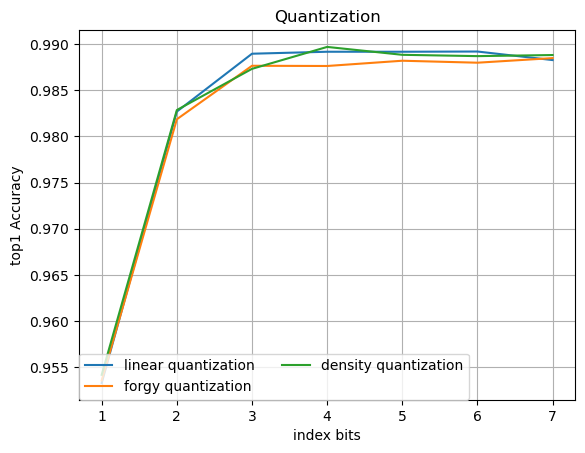

In [9]:
import matplotlib.pyplot as plt

fig = plt.figure()
for param_name, sensitivity in sensitivities.items():
    print(param_name)
    sense = [values[0] for sparsity, values in sensitivity.items()]
    sparsities = [sparsity for sparsity, values in sensitivity.items()]
    print(sense,sparsities)
    plt.plot(sparsities, sense, label=param_name.replace('_',' '))

plt.ylabel('top1 Accuracy')
plt.xlabel('index bits')
plt.title('Quantization')
plt.grid()
plt.legend(loc='lower left',
           ncol=2, borderaxespad=0.)
fig.savefig('quantization-comparison.png')

In [64]:
from collections import OrderedDict

def get_param_names(df):
    return list(set(df['parameter']))

def get_sensitivity_levels(df):
    return list(set(df['sparsity']))

def df2sensitivities(df):
    param_names = get_param_names(df)
    sparsities = get_sensitivity_levels(df)

    sensitivities = {}
    for param_name in param_names:
        sensitivities[param_name] = OrderedDict()
        param_stats = df[(df.parameter == param_name)]

        for row in range(len(param_stats.index)):
            s = param_stats.iloc[[row]].sparsity

            loss = param_stats.iloc[[row]].loss
            top1 = param_stats.iloc[[row]].top1
            top5 = param_stats.iloc[[row]].top5
            sensitivities[param_name][float(s)] = {'loss':float(loss), 'val_accuracy':float(top1), 'val_topk_accuracy':float(top5),}
    return sensitivities

def view2(level, acc):
    filtered = df[df.sparsity == level]
    s = filtered.style.apply(highlight_min_max)

    param_names = filtered['parameter']

    # Plot the sensitivities
    x = range(filtered[acc].shape[0])
    y = filtered[acc].values.tolist()
    fig = plt.figure(figsize=(20,10))
    plt.plot(x, y, label=param_names, marker="o", markersize=10, markerfacecolor="C1")
    plt.ylabel(str(acc))
    plt.xlabel('parameter')
    plt.xticks(rotation='vertical')
    plt.xticks(x, param_names)
    plt.title('Pruning Sensitivity per layer %d' % level)
    #return s

def highlight_min_max(s):
    """Highlight the max and min values in the series"""
    if s.name not in ['top1', 'top5']:
        return ['' for v in s]

    is_max = s == s.max()
    maxes = ['background-color: green' if v else '' for v in is_max]
    is_min = s == s.min()
    mins = ['background-color: red' if v else '' for v in is_min]
    return [h1 if len(h1)>len(h2) else h2 for (h1,h2) in zip(maxes, mins)]

In [75]:
import pandas as pd
import numpy as np
from utils import make_paths_relative_to_root
import matplotlib.pyplot as plt
from sensitivity import plot_sensitivities

make_paths_relative_to_root()

# df = pd.read_csv('runs/Imagenette_AlexNet/0320_234640/in_alexnet_sensitivity_analysis_notrain.csv')
# df = pd.read_csv('runs/Mnist_LeNet5/0321_095114/mnist_lenet5sensitivity_analysis.csv')
df = pd.read_csv('runs/Mnist_LeNet300/sensitivity-analysis/mnist_sensitivity_analysis.csv')
#df = pd.read_csv('../examples/sensitivity-analysis/resnet20-cifar/sensitivity_filter_wise.csv')

# df['sparsity'] = round(df['sparsity'], 2)

baseline_acc = df[df['sparsity']==0.0].top1.mean()

df['top1'] = (df['top1'] - baseline_acc)/df['top1'] * 100



In [81]:
sensitivities = df2sensitivities(df)
fig = plot_sensitivities(sensitivities,'val_accuracy')
ax = fig.axes[0]
ax.set_xlim(0.4)
ax.set_ylim((-30,2))
ax.set_ylabel('top1 accuracy % difference')
fig.savefig('lenet300_pruning_sensitivity.png')